# Orthogonal Gradient Descent

In [1]:
%load_ext autoreload
%autoreload 2

# Global imports and settings

In [106]:
import pickle
from torchvision.transforms import Compose, Resize, v2
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import AR1
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

## Custom libraries

In [4]:
import sys

sys.path.append("..")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH

# Dataset and definitions

## Preprocessing definitions

In [113]:
train_transform = Compose([
    v2.Lambda(lambda x: x.expand(3, *x.shape[1:])),
    Resize((64, 64)),
])
test_transform = Compose([
    v2.Lambda(lambda x: x.expand(3, *x.shape[1:])),
    Resize((64, 64)),
])

## Dataset loading

In [114]:
scenario = PermutedMNIST(
    10,
    dataset_root=DATASETS_PATH,
    seed=1234,
    train_transform=train_transform,
    eval_transform=test_transform
)

## Scenario creation with train test streams

In [115]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [116]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss and Strategy definitions

In [117]:
criterion = CrossEntropyLoss()
strategy = AR1(
    criterion, train_mb_size=256, train_epochs=5, evaluator=eval_plugin, eval_mb_size=128
)

# Training and evaluation

In [118]:
results = []

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

-- >> Start of training phase << --
0it [00:00, ?it/s]

  0%|          | 0/10 [00:03<?, ?it/s]


  0%|          | 0/235 [00:38<?, ?it/s]


RuntimeError: Given input size: (1024x2x2). Calculated output size: (1024x0x0). Output size is too small

# Plotting results

In [12]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"][1]

accuracies["Overall"] = eval_plugin.get_all_metrics()["Top1_Acc_Stream/eval_phase/test_stream/Task000"][1]

In [13]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(10)

<Axes: >

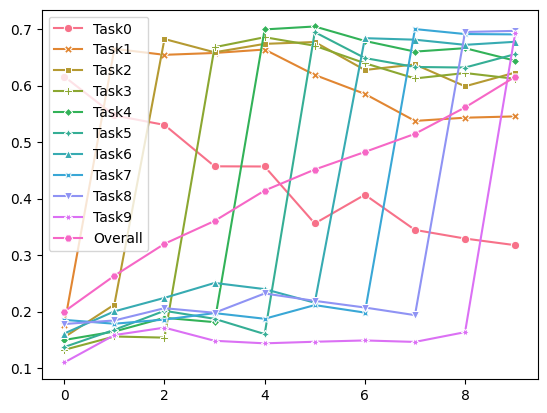

In [14]:
sns.lineplot(data=acc_df, dashes=False, markers=True)

# Store metrics

In [18]:
pickle.dump(accuracies, open(SAVED_METRICS_PATH / "agem.pkl", "wb"))